# Cifar-10 이미지 분류 v2
- 데이터 부풀리기 적용

In [16]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 전처리

In [17]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [18]:
X_train.shape, X_test.shape, y_train.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1))

In [19]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

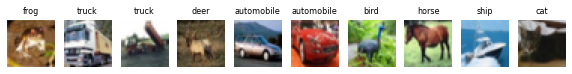

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i]), plt.axis('off')
    plt.title(class_names[y_train[i,0]], fontsize=8)
plt.show()

In [21]:
# X data: 0~1 사이의 실수(float32)로 변환
X_train = X_train.astype('float32') / 255.      # default는 64: 0이라는 값을 갖기 위해 64bit가 필요함 => 비효율적이므로, 32bit로 설정한다. 
X_test = X_test.astype(np.float32) / 255.       # 0 ~ 255 => 0 ~ 1 사이의 값일 때 최적의 성능을 구할 수 있다. 

In [22]:
# y_data: one-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test) 

- 모델 정의/설정/학습/평가

In [23]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [24]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3) ,activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

In [25]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
model_path = 'best-cifar10-v2.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 데이터 부풀리기

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
) 

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
featurewise_center=False,       # set input mean to 0 over the dataset
samplewise_center=False,        # set each sample mean to 0
featurewise_std_normalization=False, # divide inputs by std of dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,            # apply ZCA whitening
zca_epsilon=1e-06,              # epsilon for ZCA whitening
rotation_range=0,               # randomly rotate images in the range (deg 0 to 180)
width_shift_range=0.1,          # randomly shift images horizontally
height_shift_range=0.1,         # randomly shift images vertically
shear_range=0.,                 # set range for random shear
zoom_range=0.1,                 # set range for random zoom
channel_shift_range=0.,         # set range for random channel shifts
fill_mode='nearest',            # set mode for filling points outside the input boundaries
cval=0.,                        # value used for fill_mode = "constant"
horizontal_flip=True,           # randomly flip images
vertical_flip=False,            # randomly flip images
rescale=None,                   # set rescaling factor (applied before any other transformation)
preprocessing_function=None,    # set function that will be applied on each input
data_format=None,               # image data format, either "channels_first" or "channels_last"
validation_split=0.0            # fraction of images reserved for validation
)
datagen.fit(X_train)

In [29]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid),
    epochs=100, verbose=2,
    callbacks=[checkpoint, early_stop]                 
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.58444, saving model to best-cifar10-v2.h5
1250/1250 - 35s - loss: 1.8840 - accuracy: 0.3031 - val_loss: 1.5844 - val_accuracy: 0.4200 - 35s/epoch - 28ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 1.58444 to 1.45493, saving model to best-cifar10-v2.h5
1250/1250 - 33s - loss: 1.6140 - accuracy: 0.4065 - val_loss: 1.4549 - val_accuracy: 0.4756 - 33s/epoch - 27ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 1.45493 to 1.34310, saving model to best-cifar10-v2.h5
1250/1250 - 33s - loss: 1.5071 - accuracy: 0.4482 - val_loss: 1.3431 - val_accuracy: 0.5160 - 33s/epoch - 27ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 1.34310 to 1.32922, saving model to best-cifar10-v2.h5
1250/1250 - 34s - loss: 1.4260 - accuracy: 0.4853 - val_loss: 1.3292 - val_accuracy: 0.5298 - 34s/epoch - 27ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.32922 to 1.22246, saving model to best-cifar10-v2.h5
1250/1250 - 34s - lo

In [30]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.7131 - accuracy: 0.7615


[0.7131339311599731, 0.7615000009536743]

- 학습과정 시각화

In [31]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

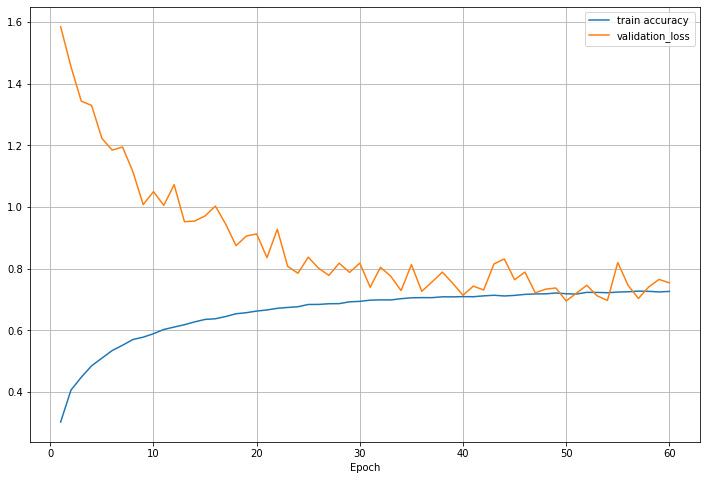

In [32]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()